In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import json
import numpy as np
import random
import os
import matplotlib.pyplot as plt

In [2]:
tf.__version__
seed = 18
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(random)
tf.keras.backend.set_floatx('float64')

In [73]:
resize = False

In [74]:
names = []

with os.scandir('training/') as entries:
    for entry in entries:
        names.append("training/"+entry.name)

In [75]:
def toRep(inp, channels, resize):
    if resize:
        cX = np.zeros((30, 30, 22+channels))
        for i in range(0, 11):
            clayer = inp[:, :] == i-1
            cX[:, :, i] = clayer
            cX[:, :, 11+i] = clayer
        return cX
    else:
        cX = np.zeros((inp.shape[0], inp.shape[1], 20+channels))
        for i in range(0, 10):
            clayer = inp[:, :] == i
            cX[:, :, i] = clayer
            cX[:, :, 10+i] = clayer
        return cX


def fromRep(rep, resize):
    if resize:
        toprint = rep[:, :, 0:11]
        toprint = np.argmax(toprint, axis=-1)-1
    else:
        toprint = rep[:, :, 0:10]
        toprint = np.argmax(toprint, axis=-1)
    return toprint

def onConf(rep, resize):
    toprint = rep[:, :, 0:10]
    maxtype = np.argmax(toprint, axis=-1)
    confidence = np.max(toprint, axis=-1)
    nonzeros = maxtype != 0
    confidence = confidence*nonzeros
    return confidence

def plot(inp):
    plt.imshow(inp)
    plt.colorbar()
    plt.show()

def load(name, channels, resize):
    X = []
    Y = []
    Xtest = []
    with open(name) as json_file:
        data = json.load(json_file) 
        l = len(data['train'])
        i = 0
        for t in data['train']:
            i += 1
            
            cin = np.array(t['input'])
            cout = np.array(t['output'])

            if not resize:
                if cin.shape != cout.shape:
                    return False
            
            if resize:
                cinr = np.full((30, 30), -1)
                cinr[:cin.shape[0], :cin.shape[1]] = cin
                coutr = np.full((30, 30), -1)
                coutr[:cout.shape[0], :cout.shape[1]] = cout
            else:
                cinr = cin
                coutr = cout
                
            cX = toRep(cinr, channels, resize)
            
            cY = toRep(coutr, channels, resize)
            
            X.append(cX)
            Y.append(cY)
            
        for t in data['test']:
            cin = np.array(t['input'])
            
            if resize:
                cinr = np.full((30, 30), -1)
                cinr[:cin.shape[0], :cin.shape[1]] = cin
            else:
                cinr = cin
                
            cX = toRep(cinr, channels, resize)
            
            Xtest.append(cX)
            
    return [np.array(X), np.array(Y), np.array(Xtest)]

In [76]:
def loss_f(x, y, resize):
    #logits = x[:, :, :, 0:11]
    #labels = y[:, :, :, 0:11]
    #return tf.nn.softmax_cross_entropy_with_logits(labels, logits)
    if resize:
        return tf.reduce_mean(tf.square(x[:, :, :, 0:11]-y[:, :, :, 0:11]))
    else:
        #y = y[:, :, :, 0:10]
        #x = x[:, :, :, 0:10]
        #print(np.sum(x[0, 0, 0, 0:10]))
        #onx = tf.math.log(x)
        #offx = tf.math.log(1-x)
        #loss = (onx*y)+(offx*(1-y))
        #print(onx)
        #print(offx)
        #return (-1)*tf.reduce_mean(loss)
        return tf.reduce_mean(tf.square((x[:, :, :, 0:10]-y[:, :, :, 0:10])))

def generate(model, cin, channels, iterations, resize):
    if resize:
        mask = np.zeros((cin.shape[0], cin.shape[1], cin.shape[2], channels+22))
        mask[:, :, :, 11:22] = 1
    else:
        mask = np.zeros((cin.shape[0], cin.shape[1], cin.shape[2], channels+20))
        mask[:, :, :, 10:20] = 1
        
        initialmask = np.zeros((cin.shape[0], cin.shape[1], cin.shape[2], channels+20))
        initialmask[:, :, :, 0:10] = 1

    xl2 = cin*mask
    
    for i in range(iterations):
        cin = model(cin)
        #Should be ok but still
        cin = (tf.nn.softmax(cin*initialmask, axis=3)*(1-mask))+(cin*(1-initialmask))+xl2
    toprint = cin.numpy()
    return toprint

def train(model, ctask, epochs, iterations, channels, verbose=False, validate=False, testtask=None, resize=False):
    trainer = tf.keras.optimizers.Adam()

    origx = ctask[0]
    x = origx.copy()
    y = ctask[1]

    if resize:
        mask = np.zeros((x.shape[0], x.shape[1], x.shape[2], channels+22))
        mask[:, :, :, 11:22] = 1 
        xl2 = origx*mask
    
        initialmask = np.zeros((x.shape[0], x.shape[1], x.shape[2], channels+22))
        initialmask[:, :, :, 0:11] = 1
    else:
        mask = np.zeros((x.shape[0], x.shape[1], x.shape[2], channels+20))
        mask[:, :, :, 10:20] = 1 
        xl2 = origx*mask
    
        initialmask = np.zeros((x.shape[0], x.shape[1], x.shape[2], channels+20))
        initialmask[:, :, :, 0:10] = 1
    
    for k in range(epochs):
        x = origx.copy()
        with tf.GradientTape() as g:
            for i in tf.range(iterations):
                x = model(x)
                #logits = x
                #tosoftmax = tf.nn.softmax(x[:, :, :, 0:11])
                #newx = np.zeros((x.shape[0], x.shape[1], x.shape[2], channels+22))
                #newx[:, :, :, 0:11] = tosoftmax
                #x = (newx*initialmask)+(x*(1-mask))
                x = (tf.nn.softmax(x*initialmask, axis=3)*(1-mask))+(x*(1-initialmask))+xl2
            lossinp = loss_f(x, y, resize)
            #yin = y.copy()
            #yin = model(y)
            #lossout = loss_f(yin, y, resize)
            loss = lossinp
            grads = g.gradient(loss, model.weights)
            #grads = [g/(tf.norm(g)+1e-8) for g in grads]
            trainer.apply_gradients(zip(grads, model.weights))
        if k%20 == 0:
            generatedinp = generate(model, ctask[0], channels, iterations, resize)
            generatedtask = generate(model, testtask, channels, iterations, resize)
            #groundtruth = wholetask[1]
            #valacc = testacc(generated, groundtruth)
            if verbose:
                print("TRAINING")
                for l in generatedinp:
                    plot(fromRep(l, resize))
                    plot(onConf(l, resize))
                print("TEST")
                plot(fromRep(generatedtask[0], resize))
                plot(onConf(generatedtask[0], resize))
                print("LOSS AT EPOCH "+str(k)+": "+str(tf.reduce_mean(loss.numpy())))
                #print("LOSS AT EPOCH "+str(k)+": "+str(loss.numpy())+" TRAIN ACCURACY: "+str(np.sum(valacc[0:-1]))+" VALIDATION ACCURACY: "+str(valacc[-1]))
    return model

TRAINING


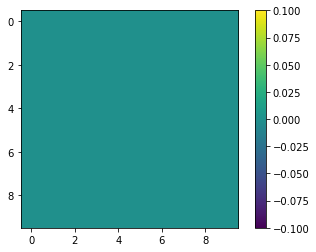

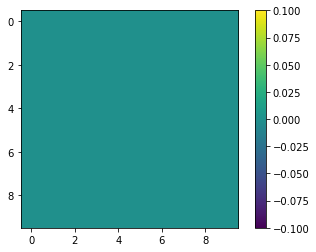

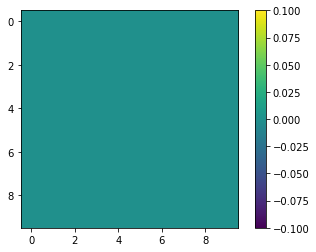

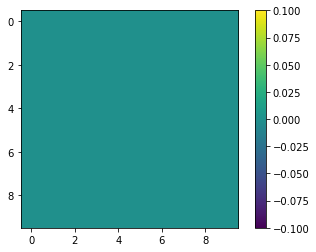

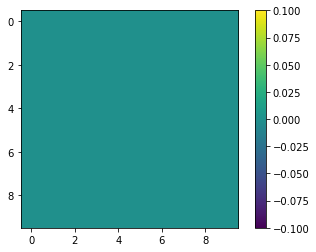

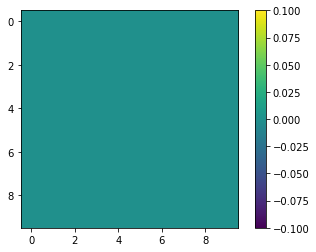

TEST


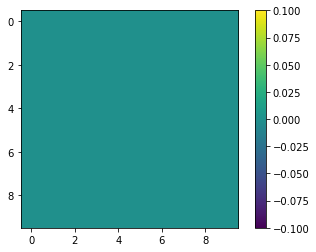

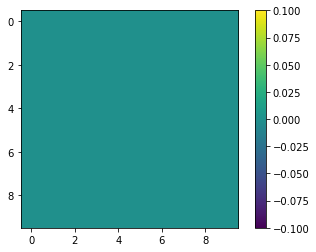

LOSS AT EPOCH 0: tf.Tensor(0.3453524698618651, shape=(), dtype=float64)
TRAINING


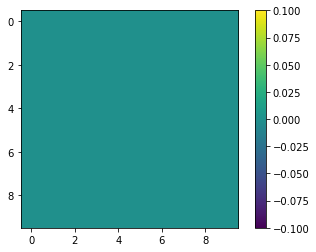

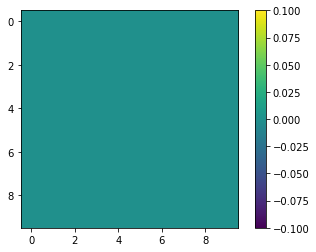

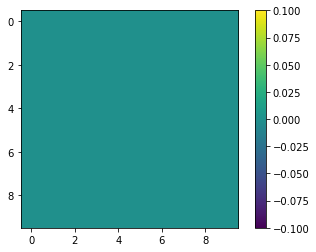

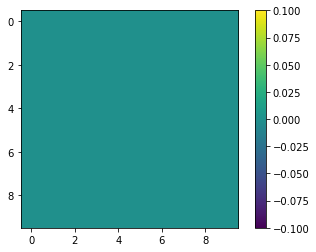

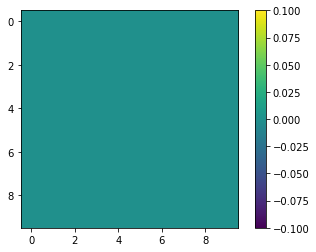

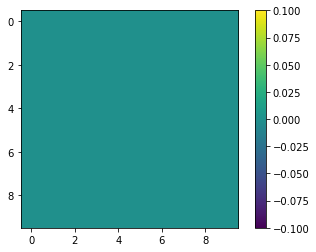

TEST


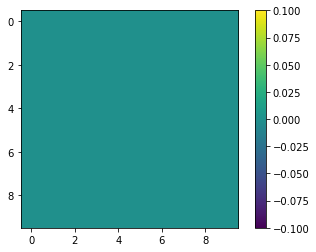

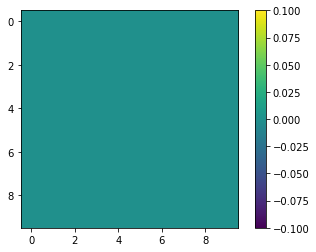

LOSS AT EPOCH 20: tf.Tensor(0.20140358507113415, shape=(), dtype=float64)
TRAINING


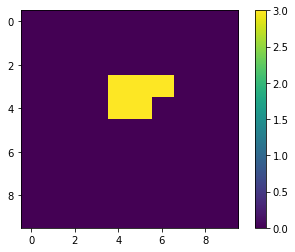

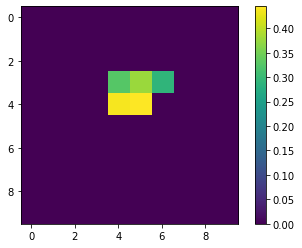

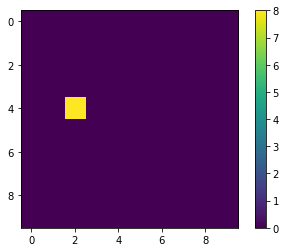

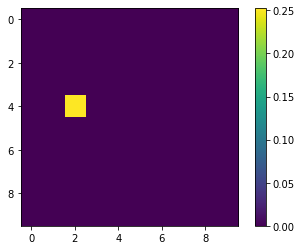

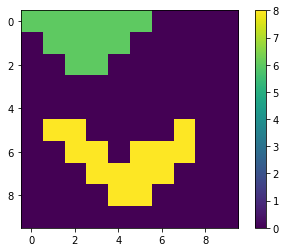

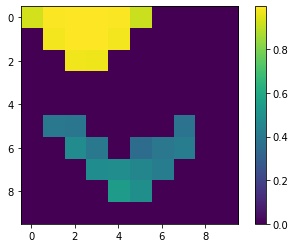

TEST


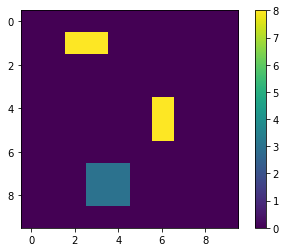

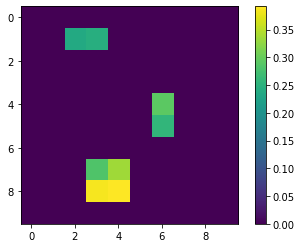

LOSS AT EPOCH 40: tf.Tensor(0.08157962484890678, shape=(), dtype=float64)
TRAINING


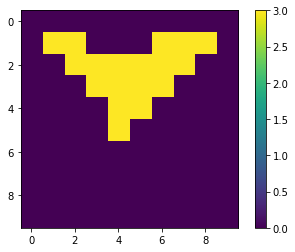

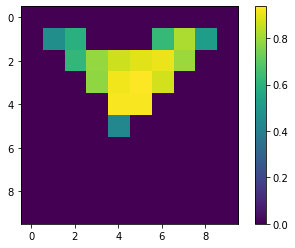

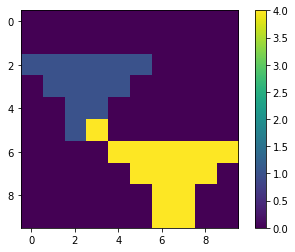

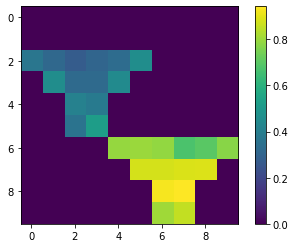

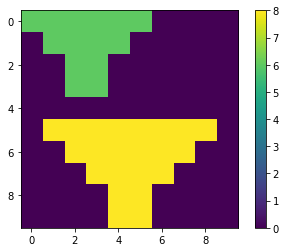

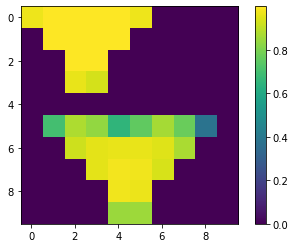

TEST


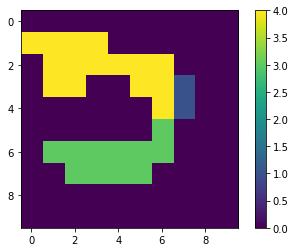

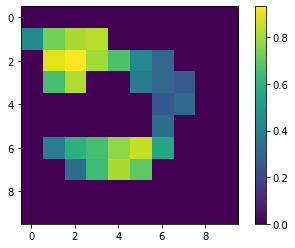

LOSS AT EPOCH 60: tf.Tensor(0.02186015690214056, shape=(), dtype=float64)
TRAINING


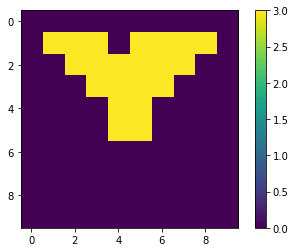

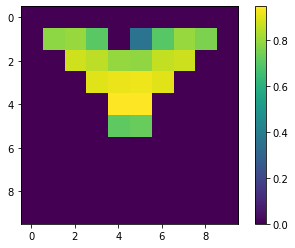

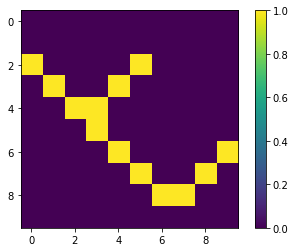

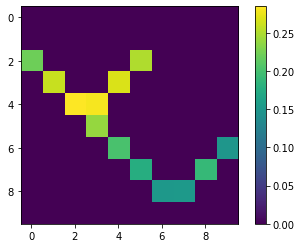

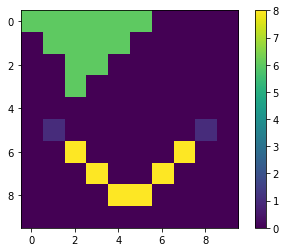

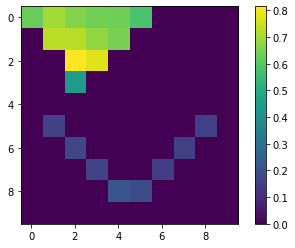

TEST


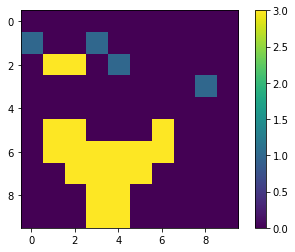

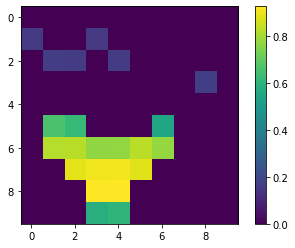

LOSS AT EPOCH 80: tf.Tensor(0.08221092162175454, shape=(), dtype=float64)
TRAINING


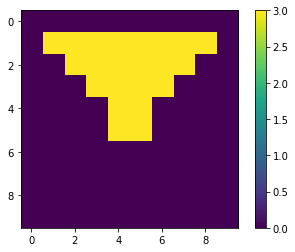

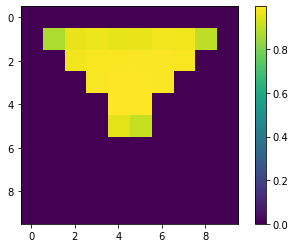

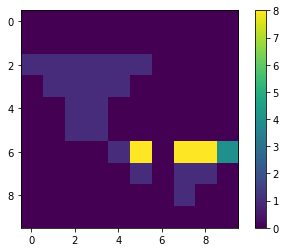

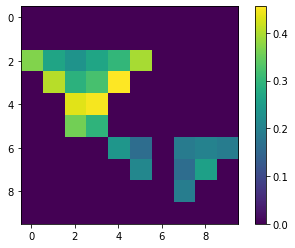

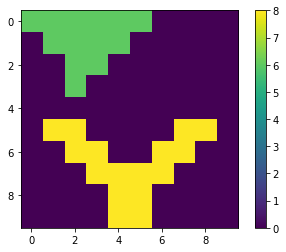

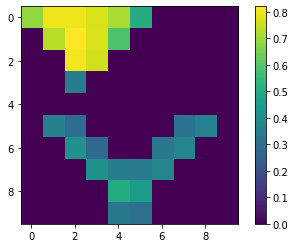

TEST


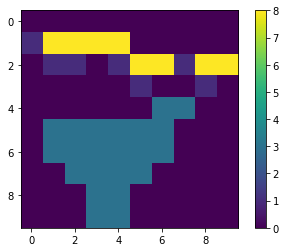

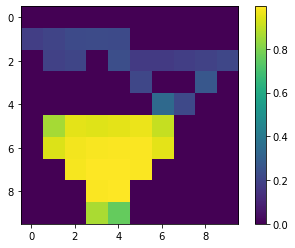

LOSS AT EPOCH 100: tf.Tensor(0.05075920856053625, shape=(), dtype=float64)
TRAINING


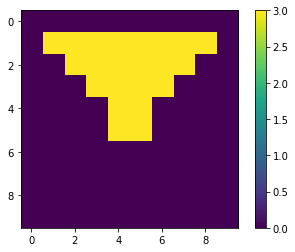

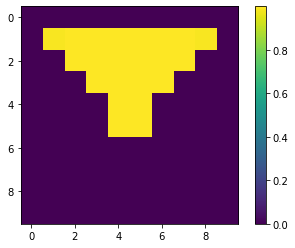

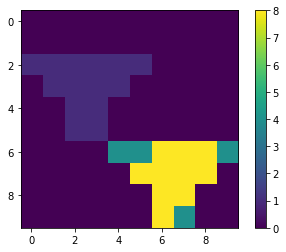

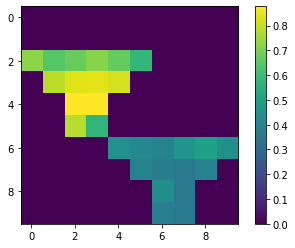

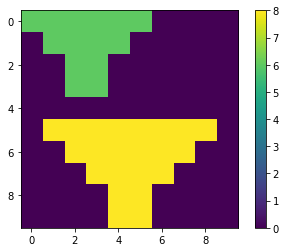

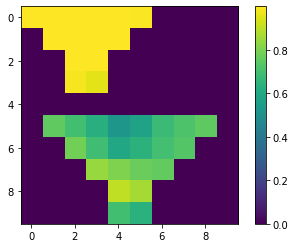

TEST


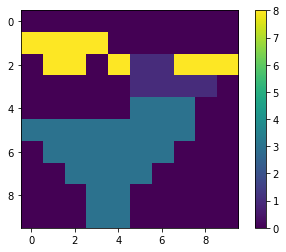

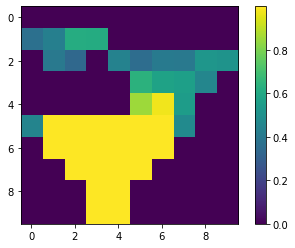

LOSS AT EPOCH 120: tf.Tensor(0.018185810947398812, shape=(), dtype=float64)
TRAINING


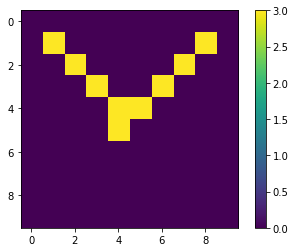

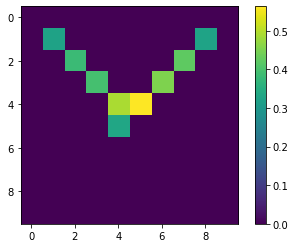

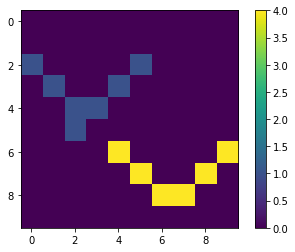

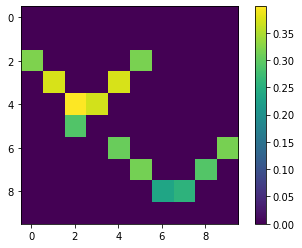

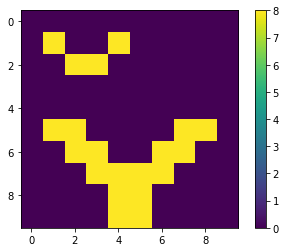

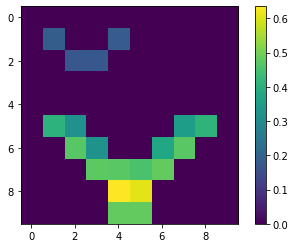

TEST


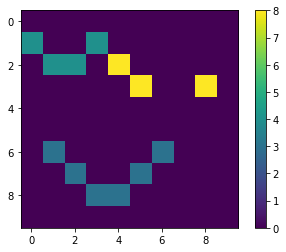

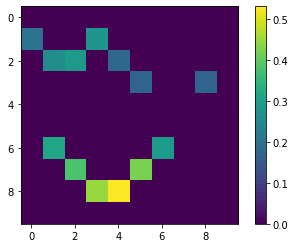

LOSS AT EPOCH 140: tf.Tensor(0.09133914522224408, shape=(), dtype=float64)
TRAINING


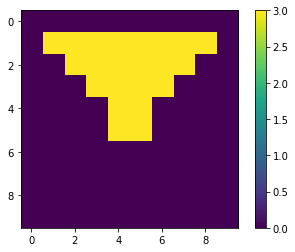

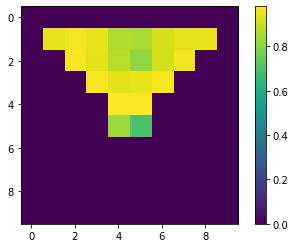

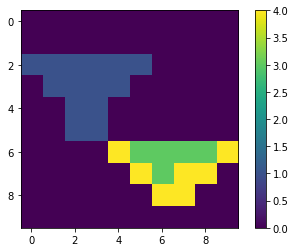

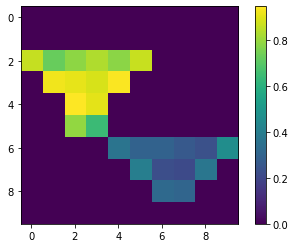

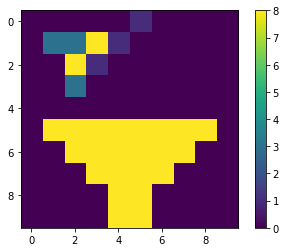

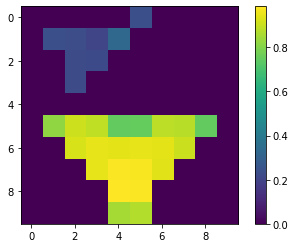

TEST


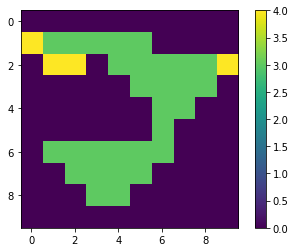

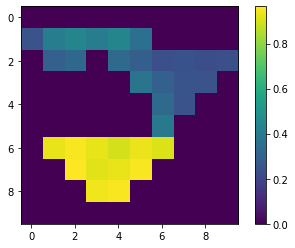

LOSS AT EPOCH 160: tf.Tensor(0.03828520087449003, shape=(), dtype=float64)
TRAINING


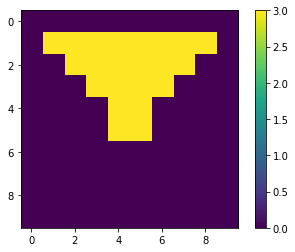

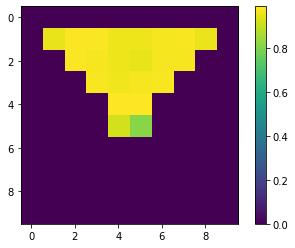

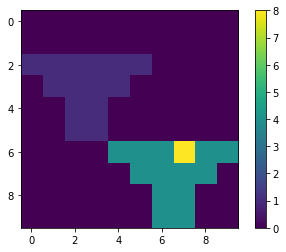

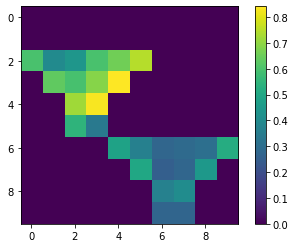

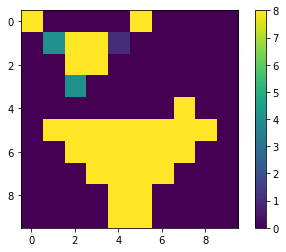

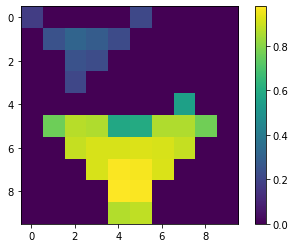

TEST


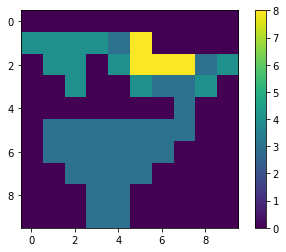

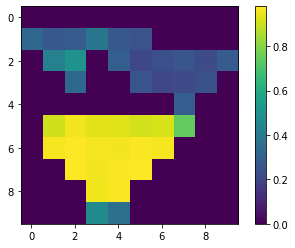

LOSS AT EPOCH 180: tf.Tensor(0.03530578098725516, shape=(), dtype=float64)


In [79]:
ntasks = 5
channels = 0
filters = 240
perceptionsize = 3
neurons = 256
epochs = 200
iterations = 20

ctask = load(names[104], channels, resize)
#task = load("training/db3e9e38.json", channels, resize)
if ctask == False:
    print("DIFFERENT SIZED IN/OUT")

if resize:
    model = tf.keras.Sequential([
        tf.keras.layers.DepthwiseConv2D((perceptionsize, perceptionsize), input_shape=(ctask[0].shape[1], ctask[0].shape[2], channels+22), strides=[1, 1], padding="same", depth_multiplier=filters, activation="relu"),
        #tf.keras.layers.Conv2D(filters, (perceptionsize, perceptionsize), input_shape=(ctask[0].shape[1], ctask[0].shape[2], channels+22), activation="relu", padding="same"),
        tf.keras.layers.Conv2D(neurons, 1, activation="relu"),
        tf.keras.layers.Conv2D(channels+22, 1, activation=None)
    ])
else:
    model = tf.keras.Sequential([
        tf.keras.layers.DepthwiseConv2D((perceptionsize, perceptionsize), input_shape=(ctask[0].shape[1], ctask[0].shape[2], channels+20), strides=[1, 1], padding="same", depth_multiplier=filters, activation="relu"),
        #tf.keras.layers.Conv2D(filters, (perceptionsize, perceptionsize), input_shape=(ctask[0].shape[1], ctask[0].shape[2], channels+20), activation="relu", padding="same"),
        tf.keras.layers.Conv2D(neurons, 1, activation="relu"),
        tf.keras.layers.Conv2D(channels+20, 1, activation=None)
    ])


cin = ctask[0:2]
ctest = ctask[2]
model = train(model, cin, epochs, iterations, channels, True, True, ctest, resize)

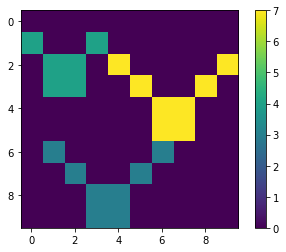

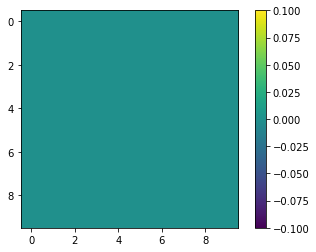

In [78]:
gen = generate(model, ctest, channels, iterations, resize)
plot(fromRep(ctest[0], resize))
plot(fromRep(gen[0], resize))

TRAINING TASKS
IN


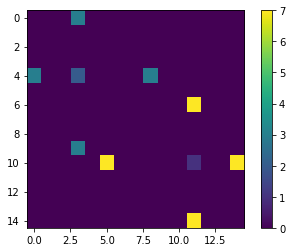

OUT


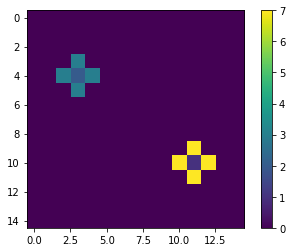

IN


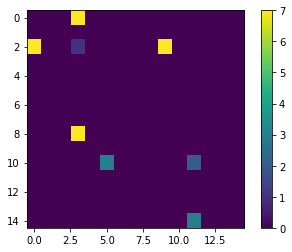

OUT


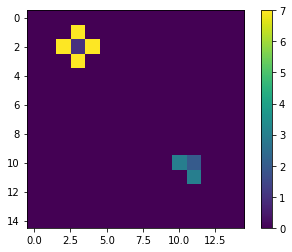

IN


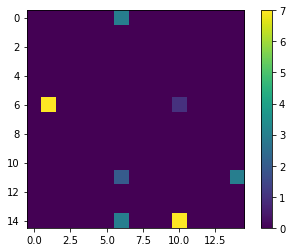

OUT


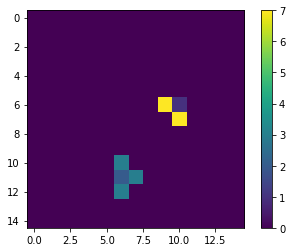

TEST IN


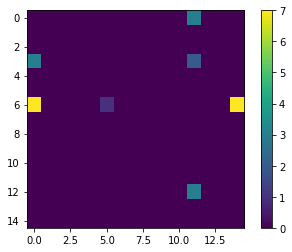

In [100]:
a = load(names[111], 10, resize)

print("TRAINING TASKS")
for t in range(len(a[0])):
    print("IN")
    plot(fromRep(a[0][t], resize))
    print("OUT")
    plot(fromRep(a[1][t], resize))
print("TEST IN")
for t in range(len(a[2])):
    plot(fromRep(a[2][t], resize))

## 

In [16]:
a

[array([None, None, None], dtype=object),
 array([None, None, None], dtype=object),
 array([None], dtype=object)]